# Парсер статей различных кодексов РФ

In [205]:
from bs4 import BeautifulSoup
import pathlib, re, pandas as pd

In [206]:
def read_file_text(path: pathlib.Path) -> str:
    """Reads a .doc file saved as HTML and returns plain text"""
    data = path.read_bytes()

    if b'<html' in data.lower():
        soup = BeautifulSoup(data, 'html.parser')
        text = soup.get_text('\n')
    else:
        try:
            text = data.decode('utf-8')
        except UnicodeDecodeError:
            text = data.decode('cp1251', errors='ignore')
    return text.replace('\u00A0', ' ')

In [207]:
# Regular Expression Patterns
re_section = re.compile(r'^\s*(?:\d+\s*\.\s*)?РАЗДЕЛ\s+([IVXLCDM]+)\.?\s*(.*)$',re.I)
re_chapter = re.compile(r'^ГЛАВА\s+((?:\d+|[IVXLCDM]+))\.?\s*(.*)$', re.I | re.M)
re_article = re.compile(r'^Статья\s+(\d+)\.?\s*(.*)$', re.I | re.M)

In [208]:
# Roman Numeral Converter
def roman_to_int(s):
    roman = {'I': 1, 'V': 5, 'X': 10, 'L': 50, 'C': 100, 'D': 500, 'M': 1000}
    prev = 0
    total = 0
    for char in reversed(s.upper()):
        value = roman[char]
        if value < prev:
            total -= value
        else:
            total += value
            prev = value
    return total

In [209]:
def parse_articles(path: pathlib.Path):

    def _save_article():
        """Saves the accumulated article in articles_meta"""
        article_end_char = sum(len(l) for l in lines[:i])
        rule_text = text[article_start_char:article_end_char]
        articles_meta.append({
            'file': path.name,
            'rule_number': rule_number,
            'rule_title': rule_title,
            'rule_text': rule_text,
            'section_title': current_section_title,
            'chapter_title': current_chapter_title,
            'start_char': article_start_char,
            'end_char': article_end_char,
            'text_length': len(rule_text)
        })

    def _peek_for_title(lines, start_idx):
        """
        Returns the first "meaningful" line after 'Article N'.
        Ignores empty, '1', '1.', '.', '2.', etc.
        """
        for ln in lines[start_idx:]:
            candidate = ln.strip()
            if candidate == '':
                continue
            if re.match(r'^[\d.]+$', candidate):
                continue
            # trim possible '1.' at the beginning of the line (our bugfix)
            candidate = re.sub(r'^\d+\s*\.?\s*', '', candidate).strip()
            if candidate:
                return candidate
        return ''
    
    def _peek_for_header(lines, start_idx):
        """
        Returns the first "content" line after the section/chapter/article title, ignoring:
        • empty lines; 
        • '1', '1.', 'n1', 'n2', '.'.
        """
        for ln in lines[start_idx:]:
            candidate = ln.strip()
            if not candidate:
                continue
            # n1 / n2 / 1 / 1. / .  => пропускаем
            if re.match(r'^(n?\d+|\\.)\\s*\\.?$', candidate, re.I):
                continue
            # убираем ведущие '1.' и т.п.
            candidate = re.sub(r'^\\d+\\s*\\.?\\s*', '', candidate).strip()
            if candidate:
                return candidate
        return ''


    text = read_file_text(path)
    lines = text.splitlines(keepends=True)

    articles_meta = []
    current_section_title = ''
    current_chapter_title = ''
    rule_number = None
    rule_title = ''
    article_start_char = None

    for i, raw_line in enumerate(lines):
        line = raw_line.strip()

        # --- раздел -------------------------------------
        m_sec = re_section.match(line)
        if m_sec:
            if rule_number is not None:
                _save_article()
            roman = m_sec.group(1).upper() 
            raw_title = m_sec.group(2).strip()
            current_section_title = (
                raw_title if raw_title else f"Раздел {roman}"
            )


        # --- глава --------------------------------------
        m_ch = re_chapter.match(line)
        if m_ch:
            if rule_number is not None:
                _save_article()

            chapter_raw = m_ch.group(1)
            try:
                chapter_num = int(chapter_raw)
            except ValueError:
                chapter_num = roman_to_int(chapter_raw)
            current_chapter_title = m_ch.group(2).strip()

            # if empty - we search further
            if current_chapter_title == '':
                current_chapter_title = _peek_for_header(lines, i + 1)

            # a backup option if you can't find anything at all
            if current_chapter_title == '':
                current_chapter_title = f'Глава {chapter_num}'


        # --- статья -------------------------------------
        m_art = re_article.match(line)
        if m_art:
            # close the previous one
            if rule_number is not None:
                _save_article()

            rule_number = int(m_art.group(1))
            rule_title = m_art.group(2).strip()

            # bugfix: if the title is empty, we search further
            if rule_title == '':
                rule_title = _peek_for_title(lines, i + 1)

            article_start_char = sum(len(l) for l in lines[:i])

    if rule_number is not None:
        _save_article()

    return articles_meta

In [210]:
data_dir = pathlib.Path('/Users/theother_archee/CursorProjects/SmartClause/parser/dataset')
files = sorted(data_dir.glob('*.doc'))  # Search for .doc files in directory

In [211]:
files

[PosixPath('/Users/theother_archee/CursorProjects/SmartClause/parser/dataset/Арбитражный процессуальный кодекс Российской Федерации.doc'),
 PosixPath('/Users/theother_archee/CursorProjects/SmartClause/parser/dataset/Бюджетный кодекс Российской Федерации.doc'),
 PosixPath('/Users/theother_archee/CursorProjects/SmartClause/parser/dataset/Водный кодекс Российской Федерации.doc'),
 PosixPath('/Users/theother_archee/CursorProjects/SmartClause/parser/dataset/Воздушный кодекс Российской Федерации.doc'),
 PosixPath('/Users/theother_archee/CursorProjects/SmartClause/parser/dataset/Градостроительный кодекс Российской Федерации.doc'),
 PosixPath('/Users/theother_archee/CursorProjects/SmartClause/parser/dataset/Гражданский кодекс Российской Федерации. Часть вторая.doc'),
 PosixPath('/Users/theother_archee/CursorProjects/SmartClause/parser/dataset/Гражданский кодекс Российской Федерации. Часть первая.doc'),
 PosixPath('/Users/theother_archee/CursorProjects/SmartClause/parser/dataset/Гражданский код

In [212]:
all_articles = []
for f in files:
    all_articles.extend(parse_articles(f))

df = pd.DataFrame(all_articles)
print(df.head())

                                                file  rule_number  \
0  Арбитражный процессуальный кодекс Российской Ф...            1   
1  Арбитражный процессуальный кодекс Российской Ф...            2   
2  Арбитражный процессуальный кодекс Российской Ф...            3   
3  Арбитражный процессуальный кодекс Российской Ф...            4   
4  Арбитражный процессуальный кодекс Российской Ф...            5   

                                          rule_title  \
0       Осуществление правосудия арбитражными судами   
1        Задачи судопроизводства в арбитражных судах   
2  Законодательство о судопроизводстве в арбитраж...   
3               Право на обращение в арбитражный суд   
4              Независимость судей арбитражных судов   

                                           rule_text    section_title  \
0  Статья 1. Осуществление правосудия арбитражным...  ОБЩИЕ ПОЛОЖЕНИЯ   
1  Статья 2. Задачи судопроизводства в арбитражны...  ОБЩИЕ ПОЛОЖЕНИЯ   
2  Статья 3. Законодательство

## Check if data was parsed correctly

In [213]:
print("Shape: ", df.shape)
print("Columns: ", df.columns)

Shape:  (8267, 9)
Columns:  Index(['file', 'rule_number', 'rule_title', 'rule_text', 'section_title',
       'chapter_title', 'start_char', 'end_char', 'text_length'],
      dtype='object')


In [214]:
for col in df.columns:
    print(f"Уникальные значения в столбце '{col}':")
    print(df[col].unique())
    print("-" * 40)


Уникальные значения в столбце 'file':
['Арбитражный процессуальный кодекс Российской Федерации.doc'
 'Бюджетный кодекс Российской Федерации.doc'
 'Водный кодекс Российской Федерации.doc'
 'Воздушный кодекс Российской Федерации.doc'
 'Градостроительный кодекс Российской Федерации.doc'
 'Гражданский кодекс Российской Федерации. Часть вторая.doc'
 'Гражданский кодекс Российской Федерации. Часть первая.doc'
 'Гражданский кодекс Российской Федерации. Часть третья.doc'
 'Гражданский кодекс Российской Федерации. Часть четвертая.doc'
 'Гражданский процессуальный кодекс Российской Федерации.doc'
 'Жилищный кодекс Российской Федерации.doc'
 'Земельный кодекс Российской Федерации.doc'
 'Кодекс административного судопроизводства Российской Федерации.doc'
 'Кодекс внутреннего водного транспорта Российской Федерации.doc'
 'Кодекс торгового мореплавания Российской Федерации.doc'
 'Лесной кодекс Российской Федерации.doc'
 'Налоговый кодекс Российской Федерации. Часть первая.doc'
 'Семейный кодекс Росс

In [215]:
# Checking for empty or NaN lines
print(df.isnull().sum())

for col in df.columns:
    num_empty = (df[col].astype(str).str.strip() == '').sum()
    print(f"Пустых строк в '{col}': {num_empty}")


file             0
rule_number      0
rule_title       0
rule_text        0
section_title    0
chapter_title    0
start_char       0
end_char         0
text_length      0
dtype: int64
Пустых строк в 'file': 0
Пустых строк в 'rule_number': 0
Пустых строк в 'rule_title': 0
Пустых строк в 'rule_text': 0
Пустых строк в 'section_title': 1588
Пустых строк в 'chapter_title': 0
Пустых строк в 'start_char': 0
Пустых строк в 'end_char': 0
Пустых строк в 'text_length': 0


In [216]:
# empty_titles = df[df['chapter_title'].astype(str).str.strip() == '']
# print(empty_titles[['file', 'rule_title', 'rule_text', 'section_title']].iloc[:5])

In [217]:
# counts = df[df['chapter_title'].astype(str).str.strip() == ''].groupby('file').size()
# print(counts)


In [218]:
# Let's calculate the average line length for each column
str_cols = df.select_dtypes(include=['object']).columns
avg_str_lengths = df[str_cols].apply(lambda col: col.astype(str).str.len().mean())

print(avg_str_lengths)

file               51.441756
rule_title         64.784807
rule_text        2040.806217
section_title      27.936132
chapter_title      40.048264
dtype: float64


In [219]:
df['file'].unique()

array(['Арбитражный процессуальный кодекс Российской Федерации.doc',
       'Бюджетный кодекс Российской Федерации.doc',
       'Водный кодекс Российской Федерации.doc',
       'Воздушный кодекс Российской Федерации.doc',
       'Градостроительный кодекс Российской Федерации.doc',
       'Гражданский кодекс Российской Федерации. Часть вторая.doc',
       'Гражданский кодекс Российской Федерации. Часть первая.doc',
       'Гражданский кодекс Российской Федерации. Часть третья.doc',
       'Гражданский кодекс Российской Федерации. Часть четвертая.doc',
       'Гражданский процессуальный кодекс Российской Федерации.doc',
       'Жилищный кодекс Российской Федерации.doc',
       'Земельный кодекс Российской Федерации.doc',
       'Кодекс административного судопроизводства Российской Федерации.doc',
       'Кодекс внутреннего водного транспорта Российской Федерации.doc',
       'Кодекс торгового мореплавания Российской Федерации.doc',
       'Лесной кодекс Российской Федерации.doc',
       

In [220]:
df[df['file'] == 'Жилищный кодекс Российской Федерации.doc'].sort_values('text_length', ascending=False).head()

,file,rule_number,rule_title,rule_text,section_title,chapter_title,start_char,end_char,text_length


## Processing of empty 'section_title'
- We have that because there is no sections (раздела) in some documents with codes (кодексами). We will replace these NaNs with "Отсутствует".

In [221]:
df['section_title'] = df['section_title'].replace(r'^\s*$', 'Отсутствует', regex=True)

In [222]:
df[df['section_title'] == 'Отсутствует']

,file,rule_number,rule_title,rule_text,section_title,chapter_title,start_char,end_char,text_length
467,Бюджетный кодекс Российской Федерации.doc,1,"Правоотношения, регулируемые Бюджетным кодексо...","Статья 1. Правоотношения, регулируемые Бюджетн...",Отсутствует,БЮДЖЕТНОЕ ЗАКОНОДАТЕЛЬСТВО РОССИЙСКОЙ ФЕДЕРАЦИИ,7248,8449,1201
468,Бюджетный кодекс Российской Федерации.doc,2,Структура бюджетного законодательства Российск...,Статья 2. Структура бюджетного законодательств...,Отсутствует,БЮДЖЕТНОЕ ЗАКОНОДАТЕЛЬСТВО РОССИЙСКОЙ ФЕДЕРАЦИИ,8449,10123,1674
469,Бюджетный кодекс Российской Федерации.doc,3,"Нормативные правовые акты, регулирующие бюджет...","Статья 3. Нормативные правовые акты, регулирую...",Отсутствует,БЮДЖЕТНОЕ ЗАКОНОДАТЕЛЬСТВО РОССИЙСКОЙ ФЕДЕРАЦИИ,10123,11914,1791
470,Бюджетный кодекс Российской Федерации.doc,4,Бюджетное законодательство Российской Федераци...,Статья 4. Бюджетное законодательство Российско...,Отсутствует,БЮДЖЕТНОЕ ЗАКОНОДАТЕЛЬСТВО РОССИЙСКОЙ ФЕДЕРАЦИИ,11914,12490,576
471,Бюджетный кодекс Российской Федерации.doc,5,Действие закона (решения) о бюджете во времени,Статья 5. Действие закона (решения) о бюджете ...,Отсутствует,БЮДЖЕТНОЕ ЗАКОНОДАТЕЛЬСТВО РОССИЙСКОЙ ФЕДЕРАЦИИ,12490,13040,550
...,...,...,...,...,...,...,...,...,...
5648,Лесной кодекс Российской Федерации.doc,119,Особо защитные участки лесов,Статья 119. Особо защитные участки лесов\n \n1...,Отсутствует,"Леса, расположенные на землях, не относящихся ...",387051,390526,3475
5649,Лесной кодекс Российской Федерации.doc,120,"Общие положения о лесах, расположенных на земл...","Статья 120. Общие положения о лесах, расположе...",Отсутствует,"Леса, расположенные на землях, не относящихся ...",390526,391111,585
5650,Лесной кодекс Российской Федерации.doc,121,"Леса, расположенные на землях обороны и безопа...","Статья 121. Леса, расположенные на землях обор...",Отсутствует,"Леса, расположенные на землях, не относящихся ...",391111,392293,1182
5651,Лесной кодекс Российской Федерации.doc,122,"Леса, расположенные на землях населенных пунктов","Статья 122. Леса, расположенные на землях насе...",Отсутствует,"Леса, расположенные на землях, не относящихся ...",392293,392839,546


In [223]:
# Add a unique identifier rule_id
df = df.reset_index(drop=True).reset_index().rename(columns={"index": "rule_id"})

## Save the final CSV

In [224]:
csv_path = data_dir / 'dataset_codes_rf.csv'
df.to_csv(csv_path, index=False)
print(f'CSV saved: {csv_path}')

CSV saved: /Users/theother_archee/CursorProjects/SmartClause/parser/dataset/dataset_codes_rf.csv


# Exploration of final dataset

In [225]:
import matplotlib.pyplot as plt
import seaborn as sns

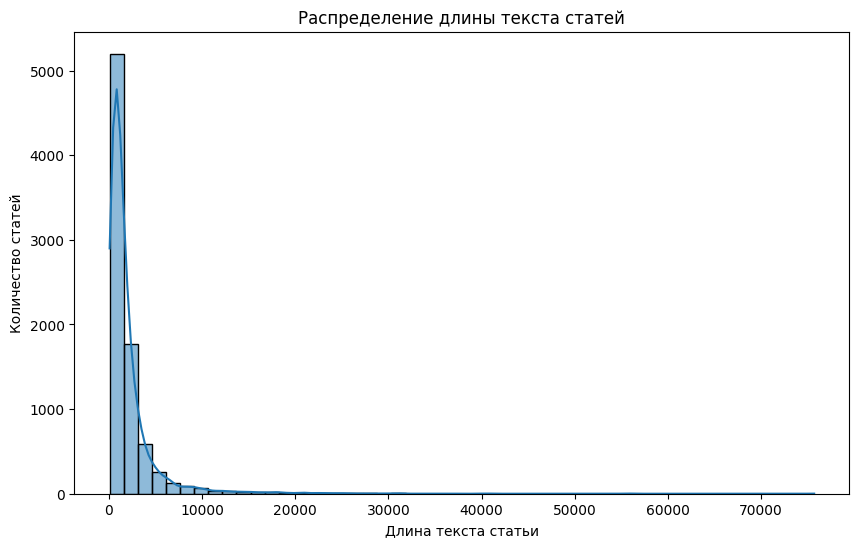

In [226]:
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Распределение длины текста статей')
plt.xlabel('Длина текста статьи')
plt.ylabel('Количество статей')
plt.show()

In [227]:
Q1 = df['text_length'].quantile(0.25)
Q3 = df['text_length'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['text_length'] < lower_bound) | (df['text_length'] > upper_bound)]

print(f'Количество выбросов: {len(outliers)}')
display(outliers[['file', 'rule_number', 'rule_title', 'text_length']].sort_values('text_length', ascending=False))

Количество выбросов: 724


,file,rule_number,rule_title,text_length
1296,Градостроительный кодекс Российской Федерации.doc,51,Разрешение на строительство,75696
1304,Градостроительный кодекс Российской Федерации.doc,55,Выдача разрешения на ввод объекта в эксплуатацию,55888
1303,Градостроительный кодекс Российской Федерации.doc,55,Выдача разрешения на ввод объекта в эксплуатацию,55552
5796,Налоговый кодекс Российской Федерации. Часть п...,84,Порядок постановки на учет и снятия с учета ор...,45965
1292,Градостроительный кодекс Российской Федерации.doc,49,Экспертиза проектной документации и результато...,40678
...,...,...,...,...
4933,Кодекс торгового мореплавания Российской Федер...,8,. Техническое управление судном,4604
1329,Градостроительный кодекс Российской Федерации.doc,55,. Совет Национального объединения саморегулиру...,4598
3319,Гражданский процессуальный кодекс Российской Ф...,113,Судебные извещения и вызовы,4591
5703,Налоговый кодекс Российской Федерации. Часть п...,25,. Порядок включения организации в реестр,4591


In [228]:
df['text_length'].mean()

np.float64(2040.8062174912302)